#Risk Analysis of Meta

This analysis was inspired for two reasons:

I recently learned how to run a risk analysis in Python and wanted to create a project showcasing this skill.

Meta (formerly known as Facebook) has just revealed their new application, Threads. In my opinion, this represents the beginning of the metaverse that Mark Zuckerberg talked about creating. With continued development, I believe Meta will become a profitable company over the years.

The analysis will focus on Meta as a singular investment, so I expect the risk profile to be on the riskier side.

To begin, I will import the necessary libraries and download the required data for analysis.

### Returns Distribution

In [1]:
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import skew, kurtosis, shapiro, norm


In [2]:
start = dt.datetime(2021, 1, 1).date()
end = dt.datetime.now()

data = yf.download("META", start = start, end = end)

print(f"{len(data)} number of records downloaded")

[*********************100%***********************]  1 of 1 completed
633 number of records downloaded


In [3]:
data['Simple Returns'] = data["Adj Close"].pct_change()

data.head()

,Open,High,Low,Close,Adj Close,Volume,Simple Returns
Date,,,,,,,
2021-01-04,274.779999,275.000000,265.200012,268.940002,268.940002,15106100,NaN
2021-01-05,268.290009,272.399994,268.209991,270.970001,270.970001,9871600,0.007548
2021-01-06,262.000000,267.750000,260.010010,263.309998,263.309998,24354100,-0.028269
2021-01-07,265.899994,271.609985,264.779999,268.739990,268.739990,15789800,0.020622
2021-01-08,268.309998,268.950012,263.179993,267.570007,267.570007,18528300,-0.004354


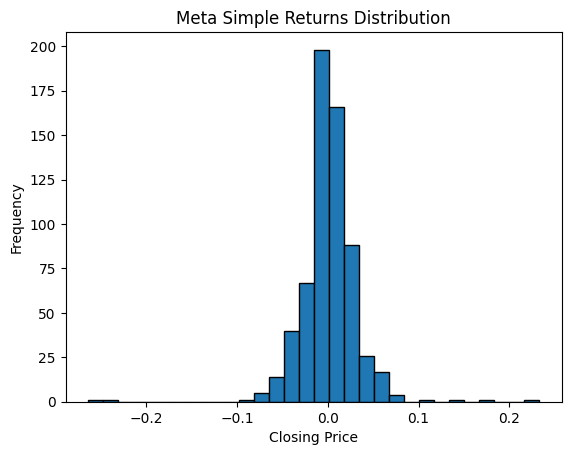

In [4]:
plt.hist(data["Simple Returns"], bins=30, edgecolor='black')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title("Meta Simple Returns Distribution")
plt.show()

In [5]:

mu = np.mean(data["Simple Returns"])
annualized_returns = ((1 + mu)** 252) - 1

std = np.std(data["Simple Returns"])
T = len(data["Simple Returns"])
std_annual = std * np.sqrt(T)

var_annual = std_annual**2

data = data.dropna()

skewness = skew(data["Simple Returns"])
kurtosis = kurtosis(data["Simple Returns"])

print("Average daily return:", mu)
print("Average annualized return:", annualized_returns)
print("Standard deviation of returns:", std)
print("Annualized volatility:", std_annual)
print("Annualized variance:", var_annual)
print("Skewness of returns:", skewness)
print("Kurtosis of returns:", kurtosis)


Average daily return: 0.0006684103079296973
Average annualized return: 0.18338991522077208
Standard deviation of returns: 0.031362938299888
Annualized volatility: 0.7890755717559848
Annualized variance: 0.6226402579420343
Skewness of returns: -0.6866439207185906
Kurtosis of returns: 19.562469453430055


Skewness: The computed value indicates that the returns are slightly skewed to the left, suggesting a higher frequency of negative returns compared to positive returns.

Kurtosis: The computed value shows a relatively high kurtosis, indicating a distribution with heavier tails. This means there is a higher likelihood of extreme positive or negative returns.

In [6]:
statistic, p_value = shapiro(data["Simple Returns"])

# Print the results
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


The rejection of the null hypothesis implies non-normality of the returns, which is consistent with the earlier computed kurtosis value indicating a higher likelihood of extreme positive and negative returns.

### Historical VaR and CVaR

Historical VaR at 95.0 % confidence level: -0.04145911471554122
Historical CVaR at 95.0 % confidence level: -0.06831463455425683


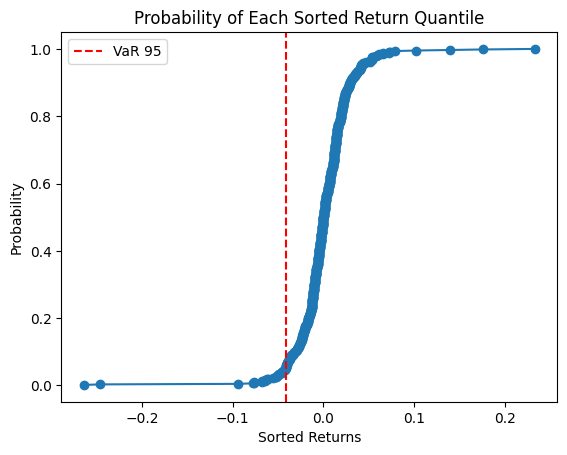

In [7]:
var_level = 0.95

hist_var = np.percentile(data["Simple Returns"], 100 * (1 - var_level))
returns = data["Simple Returns"]
returns_below_var = returns[returns <= hist_var]
hist_cvar = np.mean(returns_below_var)

print("Historical VaR at", var_level * 100, "% confidence level:", hist_var)
print("Historical CVaR at", var_level * 100, "% confidence level:", hist_cvar)

sorted_returns = np.sort(data["Simple Returns"])
sorted_returns_prob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

plt.plot(sorted_returns, sorted_returns_prob, marker='o')
plt.xlabel("Sorted Returns")
plt.ylabel("Probability")
plt.title("Probability of Each Sorted Return Quantile")

plt.axvline(x=hist_var, color='r', linestyle='--', label='VaR 95')
plt.legend()
plt.show()

1. Historical VaR: The value indicates that
there is a 5% chance of experiencing a loss of -0.0414604777965496. If you invested 1 million dollars, there is a 5% chance of losing $41,460.48.

2. Historical CVaR: The value indicates the expected shortfall if the historical VaR threshold (-0.0414604777965496) is exceeded. If you invested 1 million dollars, the expected loss if the threshold is surpassed is $68,314.63.

Expected Shortfall (CVaR) at 95.0 % confidence level: -0.06831463455425683


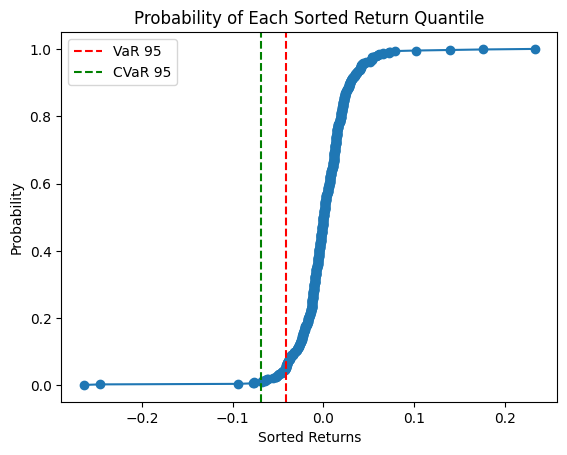

In [8]:
expected_shortfall = np.mean(returns_below_var)
print("Expected Shortfall (CVaR) at", var_level * 100, "% confidence level:", expected_shortfall)

plt.plot(sorted_returns, sorted_returns_prob, marker='o')
plt.xlabel('Sorted Returns')
plt.ylabel('Probability')
plt.title('Probability of Each Sorted Return Quantile')

plt.axvline(x=hist_var, color='r', linestyle='--', label='VaR 95')
plt.axvline(x=hist_cvar, color='g', linestyle='--', label='CVaR 95')
plt.legend()

## Parametric VaR and CVaR

In [9]:
var_level1 = 0.05

parametric_var = norm.ppf(1 - var_level1, mu, std)
print("Parametric VaR at", var_level * 100, "% confidence level:", parametric_var)

Parametric VaR at 95.0 % confidence level: 0.05225585312235572


Parametric VaR may not be a reliable indicator in this analysis due to the slightly skewed and non-normal nature of the returns data. Therefore, the computed value will not be considered for the purposes of this analysis. It was calculated for practice purposes.

In [10]:
def plot_var(array):
  d = pd.DataFrame(abs(array))
  d[1].plot(xlabel='Time', ylabel='Forecasted VaR-95', title = "Time scaled VaR")
  plt.show()

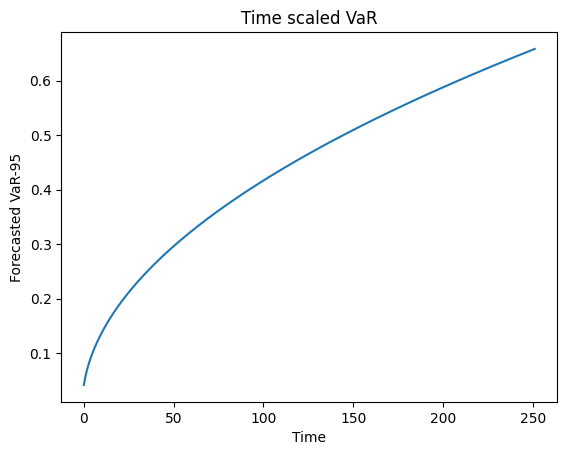

In [11]:
VaR_arr = np.zeros((252, 2))

hist_var1day = hist_var

for i in range(1,253):
  VaR_arr[i-1,0] = i
  VaR_arr[i-1,1] = hist_var1day * np.sqrt(i)

plot_var(VaR_arr)


## Monte Carlo VaR and CVaR

In [12]:
log_rets = np.log(data["Adj Close"][1:] / data["Adj Close"][:-1])
log_variance = np.mean(log_rets)
log_std = np.sqrt(log_variance)

VaR(95) at the end of the simulation period: 1.000198432383514
CVaR(95) at the end of the simulation period: 1.0001984323835136


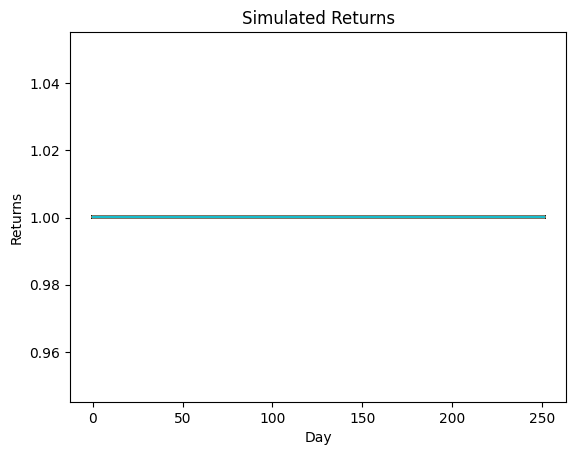

In [13]:
n_days = 252
n_sims = 1000
drift = 0.05

drift_daily = (drift - 0.5*log_std**2) / n_days

returns_simulated = np.zeros((n_days, n_sims))

for i in range(n_sims):
    z = np.random.standard_normal(n_days)
    returns_simulated[:, i] = np.exp(drift_daily + log_std*z)

returns_sorted = np.sort(returns_simulated[-1, :])
var_95 = np.percentile(returns_sorted, 5)
cvar_95 = np.mean(returns_sorted[returns_sorted <= var_95])

print("VaR(95) at the end of the simulation period:", var_95)
print("CVaR(95) at the end of the simulation period:", cvar_95)

plt.plot(returns_simulated)
plt.xlabel('Day')
plt.ylabel('Returns')
plt.title('Simulated Returns')
plt.show()




1. Monte Carlo VaR: If you invested 1 million dollars, at the computed VaR level, you can expect to lose $1,000,198.43.

2. Monte Carlo CVaR: If you invested 1 million dollars and the VaR threshold is exceeded, you can expect to lose $1,000,198.43.

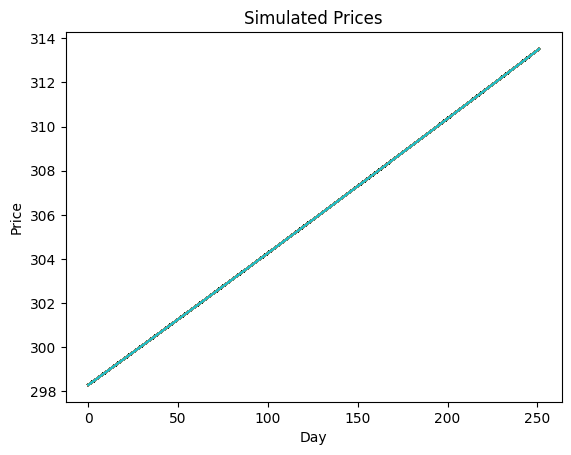

            0           1           2           3           4           5    \
0    298.290009  298.290009  298.290009  298.290009  298.290009  298.290009   
1    298.349199  298.349199  298.349199  298.349199  298.349199  298.349199   
2    298.408401  298.408401  298.408401  298.408401  298.408401  298.408401   
3    298.467615  298.467615  298.467615  298.467615  298.467615  298.467615   
4    298.526841  298.526841  298.526841  298.526841  298.526841  298.526841   
..          ...         ...         ...         ...         ...         ...   
247  313.272724  313.272724  313.272724  313.272724  313.272724  313.272724   
248  313.334887  313.334887  313.334887  313.334887  313.334887  313.334887   
249  313.397063  313.397063  313.397063  313.397063  313.397063  313.397063   
250  313.459251  313.459251  313.459251  313.459251  313.459251  313.459251   
251  313.521452  313.521452  313.521452  313.521452  313.521452  313.521452   

            6           7           8           9  

In [14]:
p0 = data['Adj Close'].iloc[-1]

prices = np.zeros_like(returns_simulated)
prices[0, :] = p0

for t in range(1, n_days):
    prices[t, :] = prices[t-1, :] * returns_simulated[t, :]

prices_df = pd.DataFrame(prices)

plt.plot(prices_df)
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Simulated Prices")
plt.show()

print(prices_df)

Conclusion:

Based on the risk analysis conducted solely on Meta as an investment, it appears that Meta's risk level exceeds my personal risk tolerance and may be too high for many investors. However, it's important to note that this analysis only considers the risk associated with investing in Meta. Combining Meta with other assets in a diversified portfolio could help mitigate the risk involved. Additionally, such diversification would provide an opportunity to benefit from Mark Zuckerberg's vision of the metaverse while managing risk more prudently.